# area_density_calc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xraylib as xrl
import scipy.ndimage as nd

def interpolate(img, zoom = 3, order = 1):
    img_intp = nd.zoom(img, zoom = zoom, order = order)
    return img_intp

def select_data(xx, yy, data_lst, lower_threshold, upper_threshold, plot = False):
    mask = np.ones_like(xx)
    for i in range(len(data_lst)):    
        masked_data = np.ma.masked_outside(data_lst[i], lower_threshold[i], upper_threshold[i])
        mask_i = ~masked_data.mask
        if plot:
            plt.figure()
            plt.pcolor(xx,yy,masked_data)
        mask *= mask_i
    plt.pcolor(xx,yy,mask,cmap = "Blues")
    plt.colorbar()
    return mask

def contour_plot(xx, yy, plot_data, title="", label ="", cmap = "magma", save = True, contour_line = True):
    fontsize = 14
    plt.pcolor(interpolate(xx),
            interpolate(yy),
            interpolate(plot_data),
            cmap = cmap)

    cbar = plt.colorbar()
    cbar.set_label(label, rotation=270, labelpad=20, fontsize=fontsize)
    if contour_line:
        plt.clabel(plt.contour(interpolate(xx),
                               interpolate(yy),
                               interpolate(plot_data),
                               levels = 12,
                               colors='white'), inline=1, fontsize=10)

    # Set plot labels and show plot
    plt.xlabel('Active material [%]', fontsize=fontsize)
    plt.ylabel('Area density [$mg/cm^2$]', fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    if save:
        plt.savefig(title+".jpg", dpi = 300)
        
def compound_generator(elements, composition, printit = False):
    compound = ""
    for i in range(len(elements)):
        compound += elements[i]
        compound += str(composition[i])
    if printit:
        print(compound)
    return compound

class Material_Abs(object):

    def __init__(self, compounds_info, energy, Kedge):
        self.compounds_info = compounds_info
        self.energy = energy
        self.Kedge = Kedge
        self.printlst = {}

    def edge_jump_calc(self,E1 = None, E2 = None):
        if E1 is None:
            mask = np.s_[:]
        else:
            mask = ~np.ma.masked_outside(self.energy * 1000, E1, E2).mask
        self.abs_max = self.abs_total[mask].max()
        self.abs_min = self.abs_total[mask].min()
        self.edge_jump = self.abs_max - self.abs_min
        self.printlst["01_abs_max"] = "Abs Max. is %.3f"%self.abs_max
        self.printlst["02_abs_min"] = "Abs Min. is %.3f"%self.abs_min
        self.printlst["03_abs_edge_jump"] = "Abs edge jump is %.3f"%self.edge_jump
        return self.edge_jump

    
    def abs_calc(self):
        self.abs_total = 0
        self.compound_name_all = ""
        self.compound_name_all_latex = ""
        self.compound_info_all = ""
        for compound_info_i in self.compounds_info:
            compound_i = compound_info_i["compound"]
            area_density_i = compound_info_i["area_density"]
            compound_info_i["abs"] = np.asarray([xrl.CS_Total_CP(compound_i, E) * area_density_i for E in self.energy])  
            self.abs_total += compound_info_i["abs"] 
            self.compound_name_all_latex += "%.1f"%(compound_info_i["area_density"]*1000) + "$\\frac{mg}{cm^2}$" + compound_info_i["compound"] + " + " 
            self.compound_name_all += "%.1f"%(compound_info_i["area_density"]*1000) + "mg/cm2 " + compound_info_i["compound"] + " + "
        self.compound_name_all_latex = self.compound_name_all_latex[:-3]
        self.compound_name_all = self.compound_name_all[:-3]
        self.printlst["00_compounds_info"] = "="*80 + "\n %s \n"%self.compound_name_all +"="*80
        self.edge_jump_calc(self.Kedge - 50, self.Kedge + 50)
        return self.abs_total
        
    def plot(self,  fontsize = 12, show_label = True, **kwargs):
        plt.plot(self.energy*1000, self.abs_total, label = self.compound_name_all_latex, **kwargs)

        plt.text(self.Kedge-30, self.abs_max - 0.1*self.edge_jump, 
                '$\Delta \mu x$ = %.2f'%(self.edge_jump), fontsize=fontsize)
                 
        plt.text(self.Kedge-30, self.abs_max - 1*self.edge_jump,  
                 '$\mu x_{max}$ = %.2f'%self.abs_max, fontsize=fontsize)
        plt.xlabel('Energy', fontsize=fontsize)
        plt.ylabel('Absorption', fontsize=fontsize)
        plt.xlim(self.Kedge - 50, self.Kedge + 100)
        plt.ylim(self.abs_min - 0.1, self.abs_max + 0.1)
        plt.title(self.compound_name_all)
        if show_label:
            plt.legend()
    
    def type_writer(self,sort = True):
        if sort:
            printlst = sorted(self.printlst)
        else: 
            printlst = self.printlst
        for items in printlst:
            print(self.printlst[items])

 2.4mg/cm2 Li1Ni0.9Mn0.4Co0.6O2 + 5.4mg/cm2 Al + 0.3mg/cm2 C + 0.3mg/cm2 CH2CF2 
Abs Max. is 0.781
Abs Min. is 0.642
Abs edge jump is 0.139
 2.4mg/cm2 Li1Ni0.9Mn0.4Co0.6O2 + 5.4mg/cm2 Al + 0.3mg/cm2 C + 0.3mg/cm2 CH2CF2 
Abs Max. is 0.785
Abs Min. is 0.543
Abs edge jump is 0.242
 2.4mg/cm2 Li1Ni0.9Mn0.4Co0.6O2 + 5.4mg/cm2 Al + 0.3mg/cm2 C + 0.3mg/cm2 CH2CF2 
Abs Max. is 0.670
Abs Min. is 0.495
Abs edge jump is 0.175


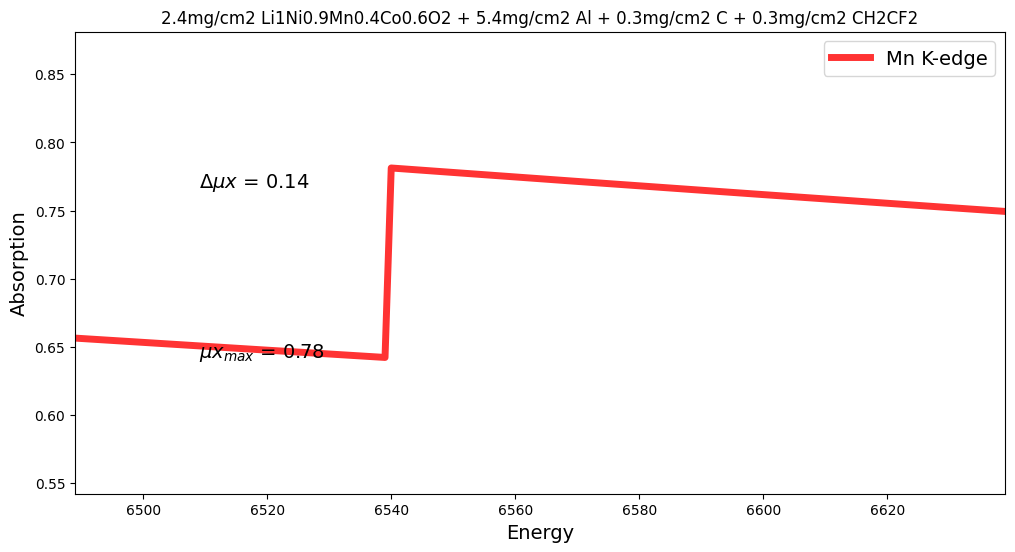

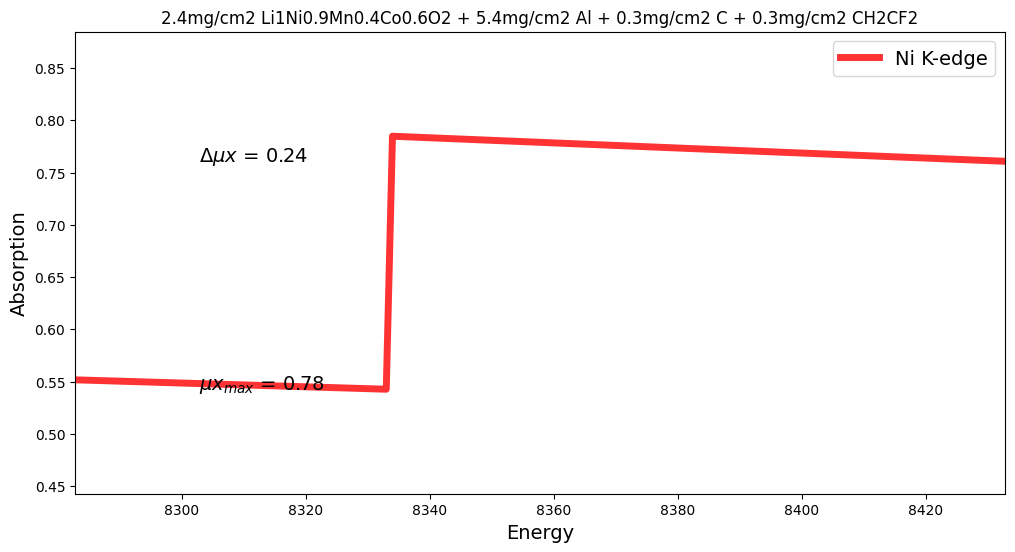

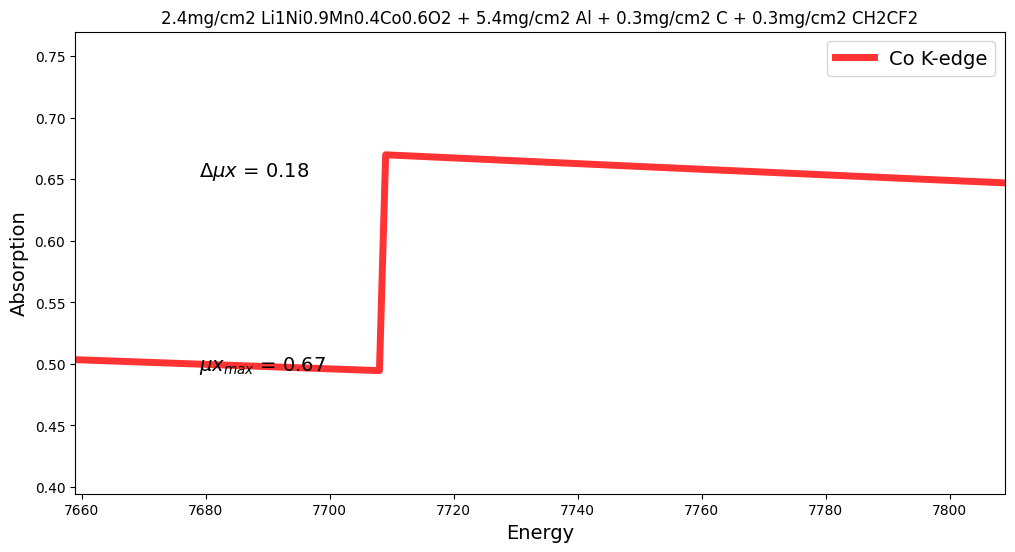

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xraylib as xrl
import scipy.ndimage as nd

def interpolate(img, zoom=3, order=1):
    """
    Interpolates the input image by a given zoom factor and interpolation order.
    
    Parameters:
    - img: The image to interpolate.
    - zoom: The zoom factor (default 3).
    - order: The order of interpolation (default 1, bilinear).
    
    Returns:
    - Interpolated image.
    """
    return nd.zoom(img, zoom=zoom, order=order)

def select_data(xx, yy, data_lst, lower_threshold, upper_threshold, plot=False):
    """
    Selects data based on thresholds and applies a mask.
    
    Parameters:
    - xx, yy: Grid data for plotting.
    - data_lst: List of data arrays to apply the thresholds.
    - lower_threshold, upper_threshold: Lists of lower and upper threshold values for masking.
    - plot: Boolean flag to show intermediate plots (default False).
    
    Returns:
    - Mask array with selected data.
    """
    mask = np.ones_like(xx)
    
    for i, data in enumerate(data_lst):    
        masked_data = np.ma.masked_outside(data, lower_threshold[i], upper_threshold[i])
        mask_i = ~masked_data.mask
        
        if plot:
            plt.figure()
            plt.pcolor(xx, yy, masked_data)
        
        mask *= mask_i
    
    plt.pcolor(xx, yy, mask, cmap="Blues")
    plt.colorbar()
    return mask

def contour_plot(xx, yy, plot_data, title="", label="", cmap="magma", save=True, contour_line=True):
    """
    Plots a contour map of the given data with optional contour lines.
    
    Parameters:
    - xx, yy: Grid data.
    - plot_data: Data to plot.
    - title: Plot title (default empty).
    - label: Label for the colorbar (default empty).
    - cmap: Colormap (default 'magma').
    - save: Boolean to save the plot as an image (default True).
    - contour_line: Boolean to add contour lines (default True).
    """
    fontsize = 14
    interp_xx, interp_yy, interp_data = map(lambda z: interpolate(z), [xx, yy, plot_data])

    plt.pcolor(interp_xx, interp_yy, interp_data, cmap=cmap)
    cbar = plt.colorbar()
    cbar.set_label(label, rotation=270, labelpad=20, fontsize=fontsize)

    if contour_line:
        plt.contour(interp_xx, interp_yy, interp_data, levels=12, colors='white', linewidths=0.5)
        plt.clabel(plt.contour(interp_xx, interp_yy, interp_data, levels=12, colors='white'), inline=1, fontsize=10)

    plt.xlabel('Active material [%]', fontsize=fontsize)
    plt.ylabel('Area density [$mg/cm^2$]', fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    if save:
        plt.savefig(f"{title}.jpg", dpi=300)

def compound_generator(elements, composition, printit=False):
    """
    Generates a chemical formula from elements and their composition.
    
    Parameters:
    - elements: List of element symbols.
    - composition: List of element composition (as integers or floats).
    - printit: Boolean to print the compound (default False).
    
    Returns:
    - Compound formula as a string.
    """
    compound = ''.join(f"{el}{comp}" for el, comp in zip(elements, composition))
    if printit:
        print(compound)
    return compound

class MaterialAbs:
    def __init__(self, compounds_info, energy, Kedge):
        """
        Initializes a MaterialAbs object to compute absorption.
        
        Parameters:
        - compounds_info: List of compound info dictionaries (compound and area density).
        - energy: Array of energy values.
        - Kedge: Edge energy value for calculation.
        """
        self.compounds_info = compounds_info
        self.energy = energy
        self.Kedge = Kedge
        self.printlst = {}

    def edge_jump_calc(self, E1=None, E2=None):
        """
        Calculates the edge jump in absorption between two energy points.
        
        Parameters:
        - E1, E2: Lower and upper energy bounds (default None).
        
        Returns:
        - Edge jump value.
        """
        mask = np.s_[:] if E1 is None else ~np.ma.masked_outside(self.energy * 1000, E1, E2).mask
        self.abs_max = self.abs_total[mask].max()
        self.abs_min = self.abs_total[mask].min()
        self.edge_jump = self.abs_max - self.abs_min
        self.printlst.update({
            "01_abs_max": f"Abs Max. is {self.abs_max:.3f}",
            "02_abs_min": f"Abs Min. is {self.abs_min:.3f}",
            "03_abs_edge_jump": f"Abs edge jump is {self.edge_jump:.3f}"
        })
        return self.edge_jump

    def abs_calc(self):
        """
        Calculates the total absorption for all compounds.
        
        Returns:
        - Total absorption as an array.
        """
        self.abs_total = np.zeros_like(self.energy)
        self.compound_name_all_latex = ""
        self.compound_name_all = ""

        for compound_info in self.compounds_info:
            compound = compound_info["compound"]
            area_density = compound_info["area_density"]
            compound_info["abs"] = np.array([xrl.CS_Total_CP(compound, E) * area_density for E in self.energy])
            self.abs_total += compound_info["abs"]
            self.compound_name_all_latex += f"{area_density * 1000:.1f}$\\frac{{mg}}{{cm^2}}$ {compound} + "
            self.compound_name_all += f"{area_density * 1000:.1f}mg/cm² {compound} + "

        self.compound_name_all_latex = self.compound_name_all_latex.rstrip(" + ")
        self.compound_name_all = self.compound_name_all.rstrip(" + ")
        self.printlst["00_compounds_info"] = "="*80 + f"\n {self.compound_name_all} \n" + "="*80
        
        self.edge_jump_calc(self.Kedge - 50, self.Kedge + 50)
        return self.abs_total

    def plot(self, fontsize=12, show_label=True, **kwargs):
        """
        Plots the absorption spectrum.
        
        Parameters:
        - fontsize: Font size for labels (default 12).
        - show_label: Boolean to show legend (default True).
        """
        plt.plot(self.energy * 1000, self.abs_total, label=self.compound_name_all_latex, **kwargs)
        plt.text(self.Kedge - 30, self.abs_max - 0.1 * self.edge_jump, f'$\\Delta \\mu x$ = {self.edge_jump:.2f}', fontsize=fontsize)
        plt.text(self.Kedge - 30, self.abs_max - self.edge_jump, f'$\\mu x_{{max}}$ = {self.abs_max:.2f}', fontsize=fontsize)
        plt.xlabel('Energy', fontsize=fontsize)
        plt.ylabel('Absorption', fontsize=fontsize)
        plt.xlim(self.Kedge - 50, self.Kedge + 100)
        plt.ylim(self.abs_min - 0.1, self.abs_max + 0.1)
        plt.title(self.compound_name_all)
        if show_label:
            plt.legend()

    def type_writer(self, sort=True):
        """
        Prints the calculated absorption values in order.
        
        Parameters:
        - sort: Boolean to sort output keys (default True).
        """
        sorted_printlst = sorted(self.printlst) if sort else self.printlst
        for item in sorted_printlst:
            print(self.printlst[item])


# $I = I_{0}e^{-abs}$

In [57]:
np.e ** (-5) * 100

0.6737946999085469

In [60]:
# Material basic information
area_density = 10/1000 #mg/cm2
ratio = 0.8 
material_info = {"compound":compound_generator(elements = ["Li", "Ni", "Mn","Co", "O"],
                                               composition = [1, 0.9, 0.04, 0.06, 2]),
                 "area_density":area_density * ratio, # g/cm2
                }

carbon_info = {"compound":"C",
               "area_density":area_density * 0.1, # g/cm2
               }

PVDF_info =  {"compound":"CH2CF2",
              "area_density":area_density * 0.1, # g/cm2
            }

Al_plate_into = {"compound":"Al",
                 "area_density": 2.7 *  20/1e4 # g/cm2 # Al_density = 2.7 #g/cm³, thickness = 20/1e4 cm
                }

Mn_Kedge = 6539 #eV
Ni_Kedge = 8332.8 #eV
Co_Kedge = 7708.9 #eV

# Material absorption calculation combining all the components
test = Material_Abs([material_info, 
                     Al_plate_into,
                     carbon_info,
                     PVDF_info
                     ],
                     energy = np.arange(6200, 8500)/1000.,
                     Kedge = Mn_Kedge)

test.abs_calc();
plt.figure(figsize=(12,6))
test.plot(fontsize=14, lw=5, alpha = 0.8, color = 'r', show_label=False)
test.type_writer()
plt.legend(["Mn K-edge"], fontsize = 14)

test = Material_Abs([material_info, 
                     Al_plate_into,
                     carbon_info,
                     PVDF_info
                     ],
                     energy = np.arange(6200, 8500)/1000.,
                     Kedge = Ni_Kedge)

test.abs_calc();

plt.figure(figsize=(12,6))
test.plot(fontsize=14, lw=5, alpha = 0.8, color = 'r', show_label=False)
test.type_writer()
plt.legend(["Ni K-edge"], fontsize = 14)


plt.figure(figsize=(12,6))
test = Material_Abs([material_info, 
                     Al_plate_into,
                     carbon_info,
                     PVDF_info
                     ],
                     energy = np.arange(6200, 8500)/1000.,
                     Kedge = Co_Kedge)

test.abs_calc();

test.plot(fontsize=14, lw=5, alpha = 0.8, color = 'r', show_label=False)
test.type_writer()
plt.legend(["Co K-edge"], fontsize = 14)


 8.0mg/cm2 Li1Ni0.9Mn0.04Co0.06O2 + 5.4mg/cm2 Al + 1.0mg/cm2 C + 1.0mg/cm2 CH2CF2 
Abs Max. is 1.048
Abs Min. is 0.977
Abs edge jump is 0.071
 8.0mg/cm2 Li1Ni0.9Mn0.04Co0.06O2 + 5.4mg/cm2 Al + 1.0mg/cm2 C + 1.0mg/cm2 CH2CF2 
Abs Max. is 1.839
Abs Min. is 0.604
Abs edge jump is 1.235
 8.0mg/cm2 Li1Ni0.9Mn0.04Co0.06O2 + 5.4mg/cm2 Al + 1.0mg/cm2 C + 1.0mg/cm2 CH2CF2 
Abs Max. is 0.750
Abs Min. is 0.660
Abs edge jump is 0.089


In [68]:
test.abs_calc()
test.edge_jump

0.07059243820349681

In [76]:
ratio = 0.8 

Mn_Kedge = 6539 #eV
Ni_Kedge = 8332.8 #eV
Co_Kedge = 7708.9 #eV

edge_jump_Mn = []
edge_jump_Ni = []
edge_jump_Co = []

for area_density in np.arange(1, 21, 1):
    area_density = area_density/1000 #mg/cm2

    material_info = {"compound":compound_generator(elements = ["Li", "Ni", "Mn","Co", "O"],
                                               composition = [1, 0.9, 0.04, 0.06, 2]),
                 "area_density":area_density * ratio, # g/cm2
                }

    carbon_info = {"compound":"C",
                "area_density":area_density * 0.1, # g/cm2
                }

    PVDF_info =  {"compound":"CH2CF2",
                "area_density":area_density * 0.1, # g/cm2
                }

    Al_plate_into = {"compound":"Al",
                    "area_density": 2.7 *  20/1e4 # g/cm2 # Al_density = 2.7 #g/cm³, thickness = 20/1e4 cm
                    }
    # print(area_density_i)
    # Material absorption calculation combining all the components
    test = Material_Abs([material_info, 
                        Al_plate_into,
                        carbon_info,
                        PVDF_info
                        ],
                        energy = np.arange(6200, 8500)/1000.,
                        Kedge = Mn_Kedge)

    test.abs_calc();
    edge_jump_Mn.append(test.edge_jump)

    test = Material_Abs([material_info, 
                        Al_plate_into,
                        carbon_info,
                        PVDF_info
                        ],
                        energy = np.arange(6200, 8500)/1000.,
                        Kedge = Ni_Kedge)

    test.abs_calc();
    edge_jump_Ni.append(test.edge_jump)

    test = Material_Abs([material_info, 
                        Al_plate_into,
                        carbon_info,
                        PVDF_info
                        ],
                        energy = np.arange(6200, 8500)/1000.,
                        Kedge = Co_Kedge)

    test.abs_calc();
    edge_jump_Co.append(test.edge_jump)

In [90]:
import plotly.express as px
import pandas as pd
import numpy as np

# Assuming edge_jump_Ni, edge_jump_Mn, edge_jump_Co are lists or arrays
# Create a range for x values
x = np.arange(1, 21, 1)

# Create a DataFrame to store the data
df = pd.DataFrame({
    'X': x,
    'Ni': edge_jump_Ni,
    'Mn': edge_jump_Mn,
    'Co': edge_jump_Co
})

# Melt the DataFrame to long format suitable for Plotly
df_melted = df.melt(id_vars='X', value_vars=['Ni', 'Mn', 'Co'], var_name='Element', value_name='Edge Jump')

# Create the line plot
fig = px.line(df_melted, x='X', y='Edge Jump', color='Element', markers=True,
              labels={'Edge Jump': 'Edge Jump Value', 'X': 'Index'})

# Update layout and axis properties
fig.update_layout(
    title='Edge Jump Comparison',
    xaxis_title=r'Area density [mg/cm2]',
    yaxis_title='Edge Jump Value',
    legend_title='Element',
    yaxis=dict(tickmode='array', tickvals=np.arange(0, 2.6, 0.2))
)

# Adding grid lines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightBlue')

# Show the figure
fig.show()